In [2]:
# =======================
# 0. SETUP AND LIBRARIES
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import os
import warnings

warnings.filterwarnings('ignore')

# ===========================
# 1. LOCATE AND LOAD DATASET
# ===========================
# Discover files in Kaggle input path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Define dataset path (adjust if needed)
data_path = "/Users/rudolphsurovcik/Library/CloudStorage/GoogleDrive-grs3@lehigh.edu/My Drive/Lehigh Fall 2025/BIS 411 - Fall 2025/Data Files/archive/Stress_Dataset.csv"

# Load CSV
df = pd.read_csv(data_path)

# Drop duplicate column if present
dup_col = 'Have you been dealing with anxiety or tension recently?.1'
if dup_col in df.columns:
    df.drop(dup_col, axis=1, inplace=True)

# Map stress level to numeric
df['stress_level'] = df['Which type of stress do you primarily experience?'].map({
    'No Stress - Currently experiencing minimal to no stress.': 0,
    'Eustress (Positive Stress) - Stress that motivates and enhances performance.': 1,
    'Distress (Negative Stress) - Stress that causes anxiety and impairs well-being.': 2
})

# Rename key columns
df.rename(columns={
    'Have you been dealing with anxiety or tension recently?': 'anxiety_level',
    'Have you been feeling sadness or low mood?': 'depression',
    'Do you lack confidence in your academic performance?': 'academic_performance'
}, inplace=True)


DATASET OVERVIEW
Shape: (843, 26)
Columns: ['Gender', 'Age', 'Have you recently experienced stress in your life?', 'Have you noticed a rapid heartbeat or palpitations?', 'anxiety_level', 'Do you face any sleep problems or difficulties falling asleep?', 'Have you been getting headaches more often than usual?', 'Do you get irritated easily?', 'Do you have trouble concentrating on your academic tasks?', 'depression', 'Have you been experiencing any illness or health issues?', 'Do you often feel lonely or isolated?', 'Do you feel overwhelmed with your academic workload?', 'Are you in competition with your peers, and does it affect you?', 'Do you find that your relationship often causes you stress?', 'Are you facing any difficulties with your professors or instructors?', 'Is your working environment unpleasant or stressful?', 'Do you struggle to find time for relaxation and leisure activities?', 'Is your hostel or home environment causing you difficulties?', 'academic_performance', 'Do you 

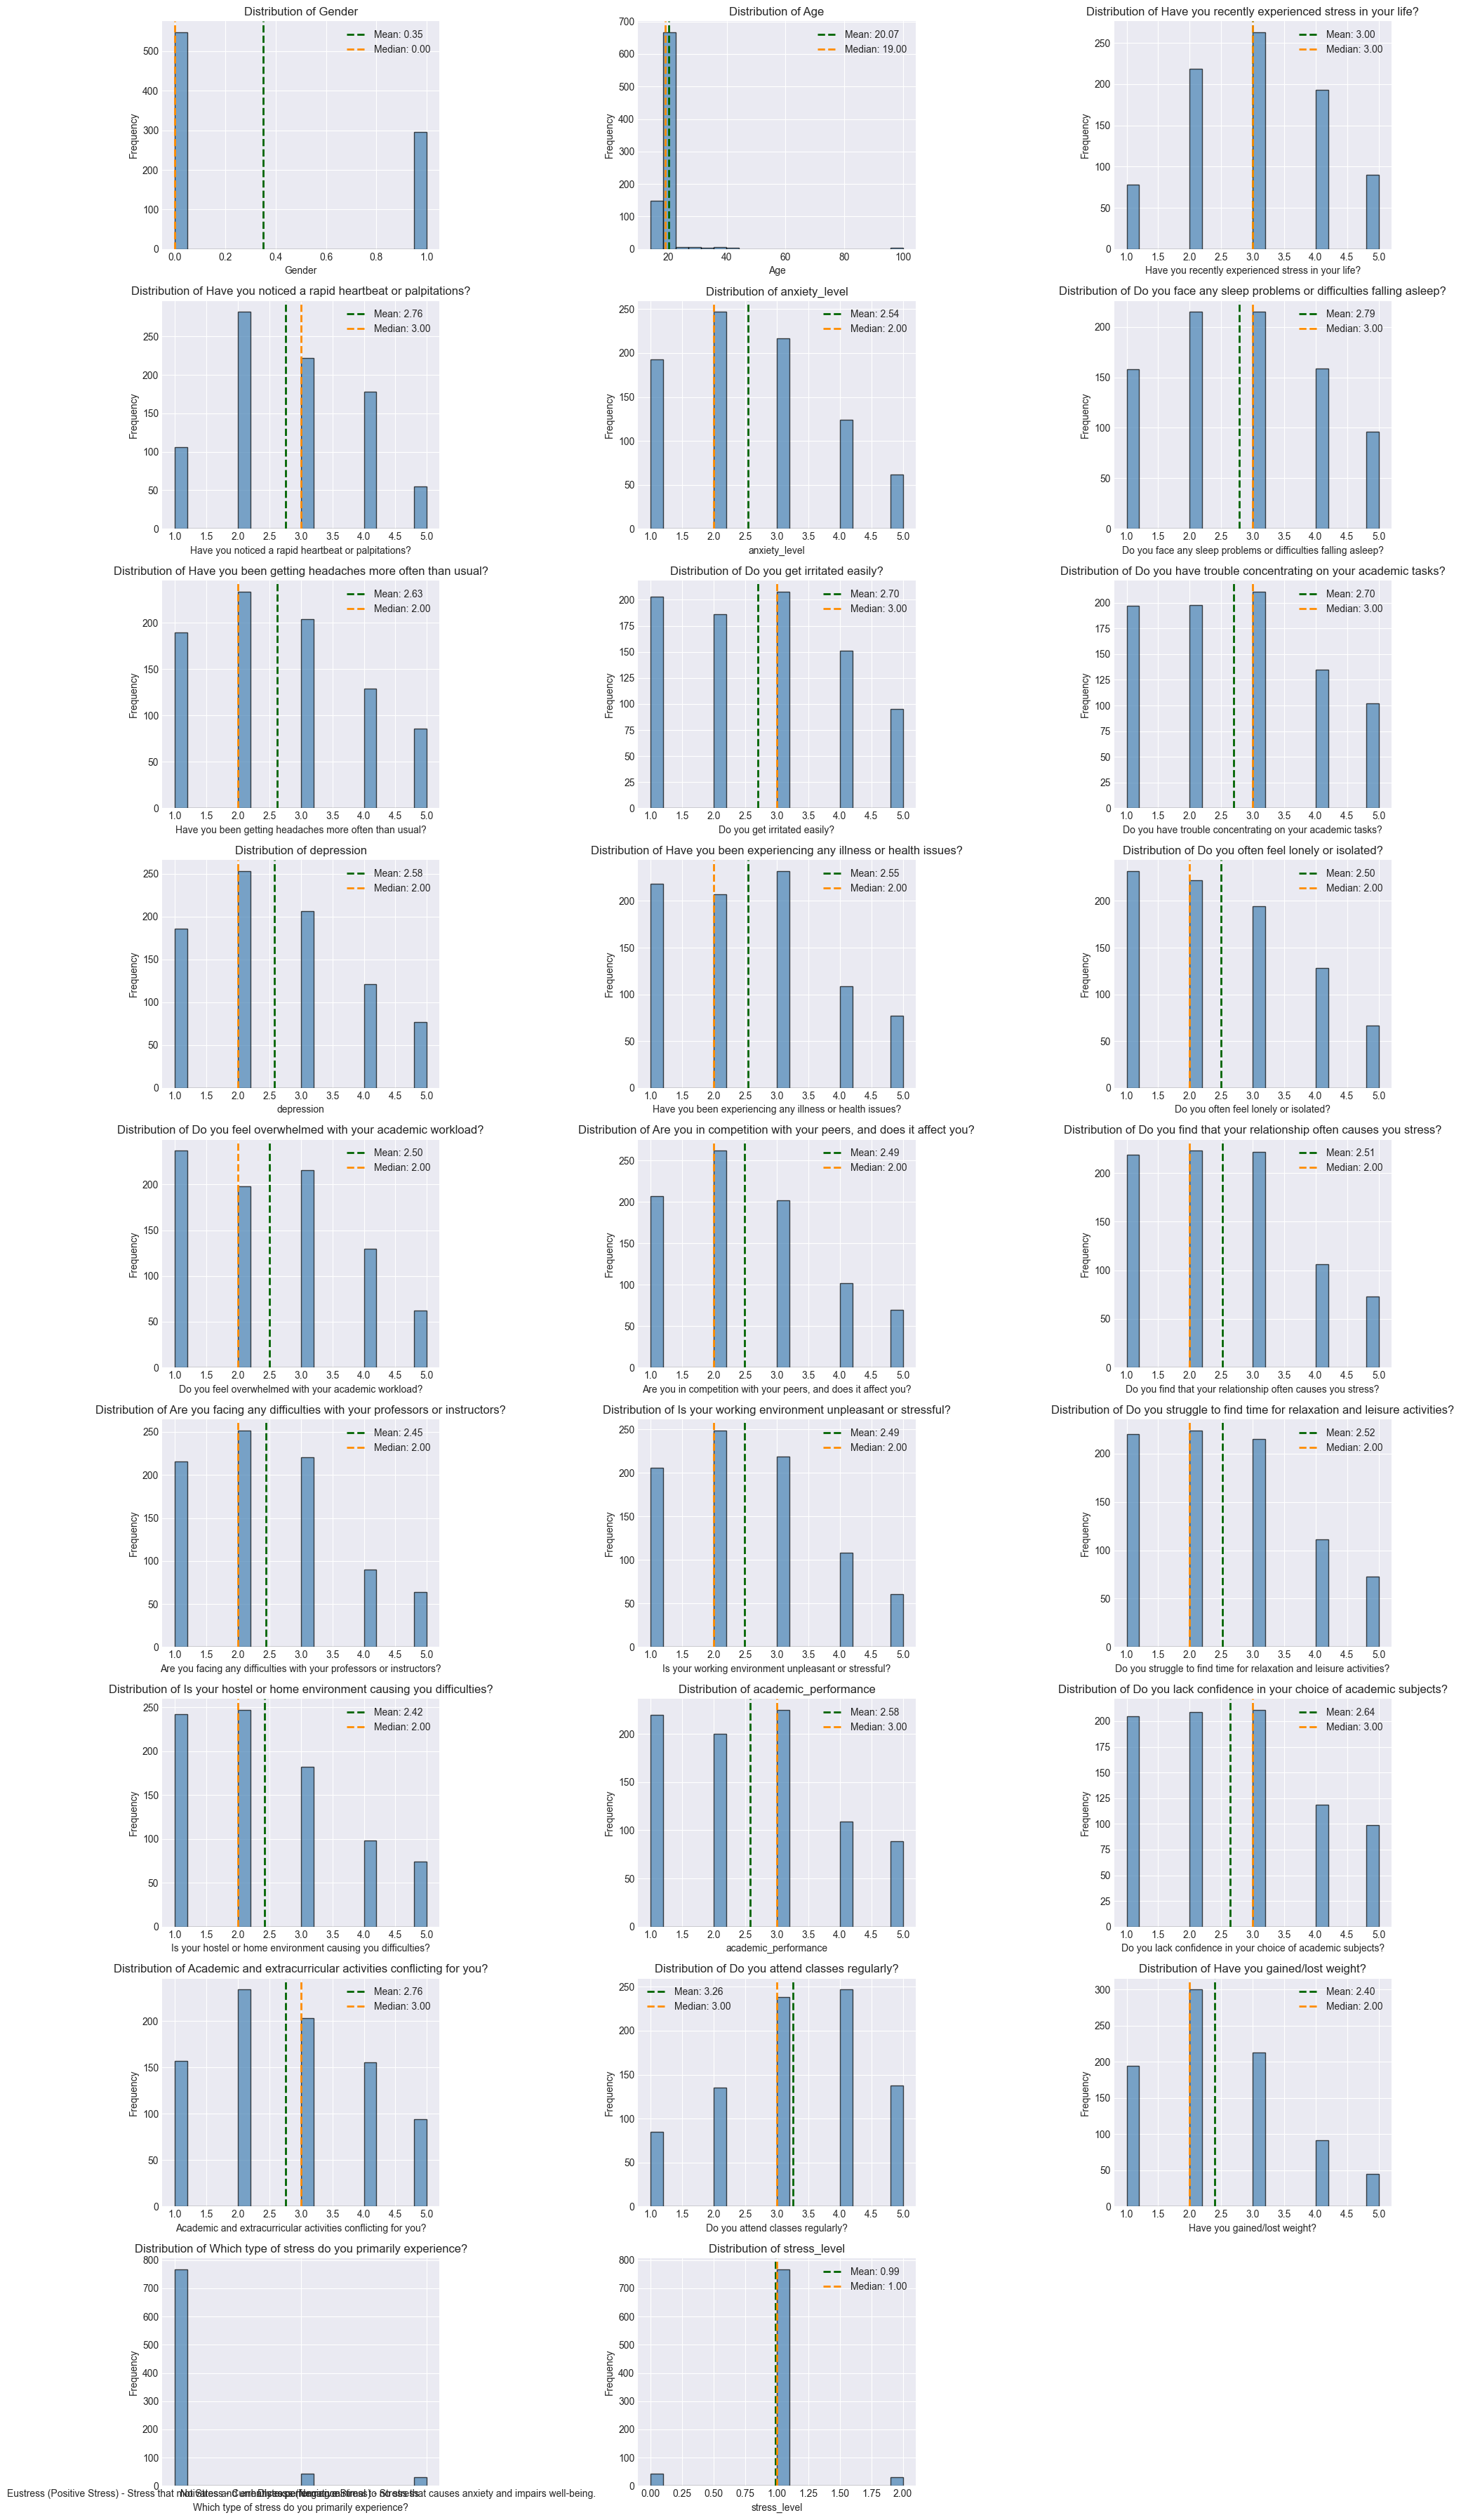

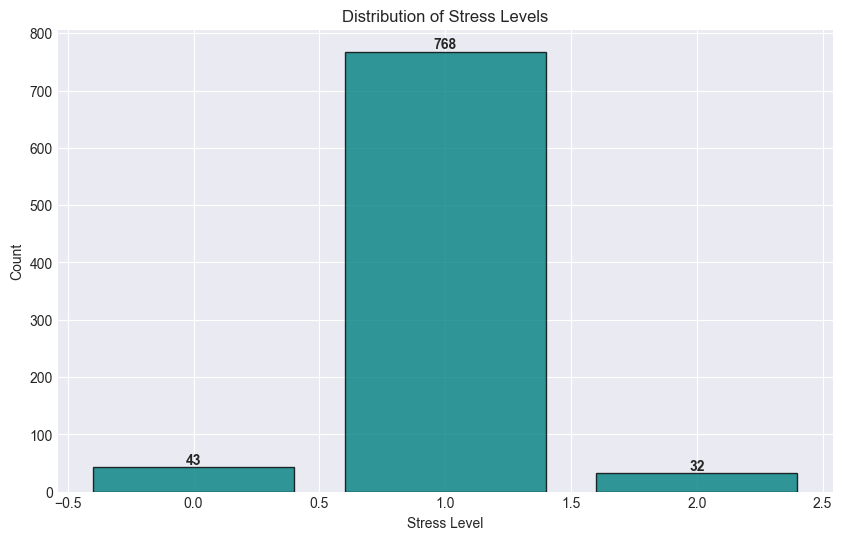

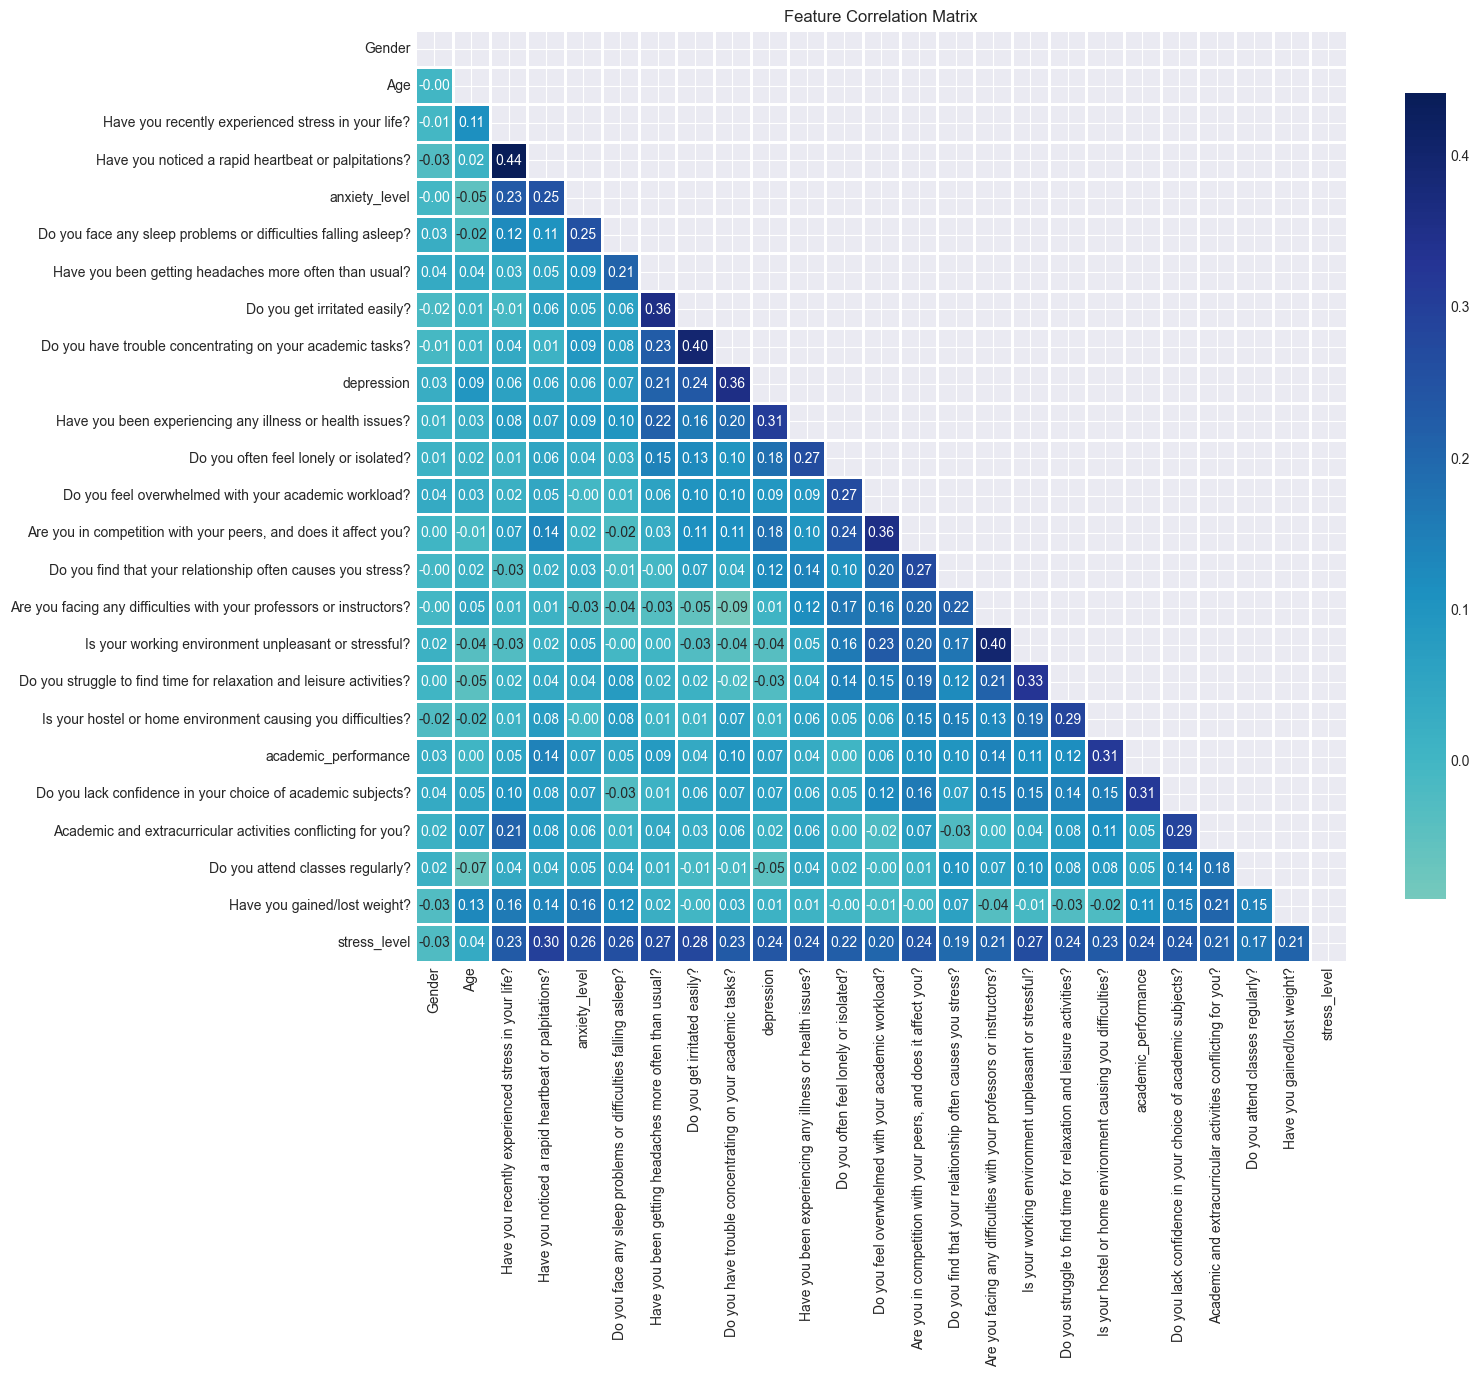

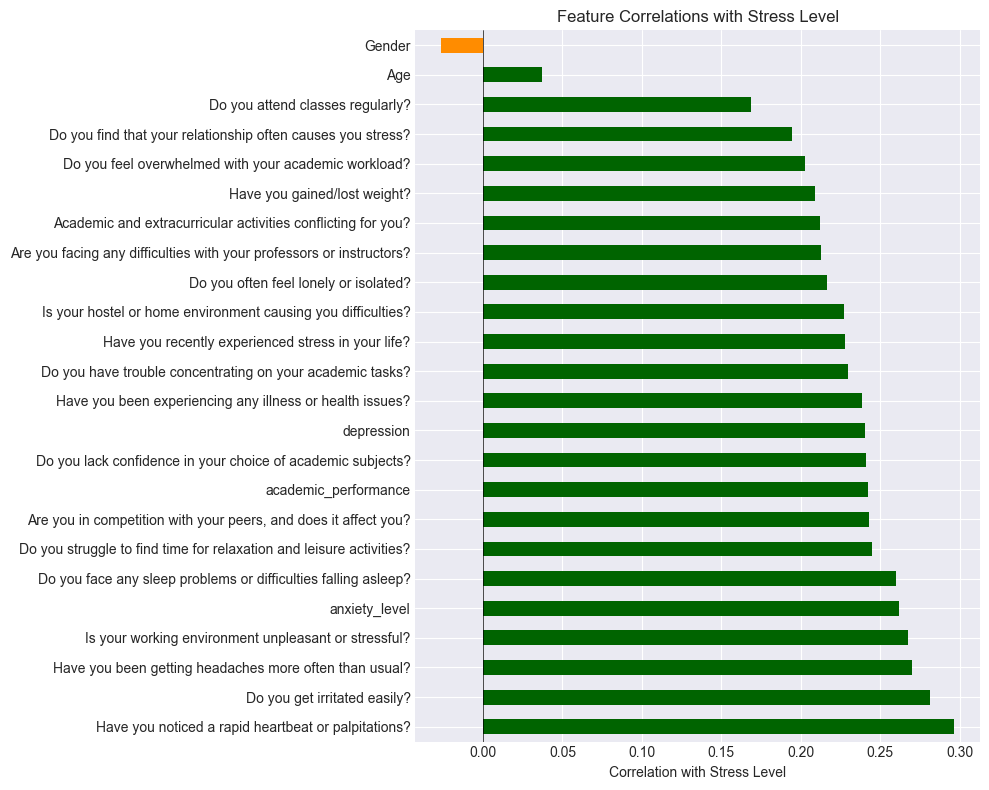

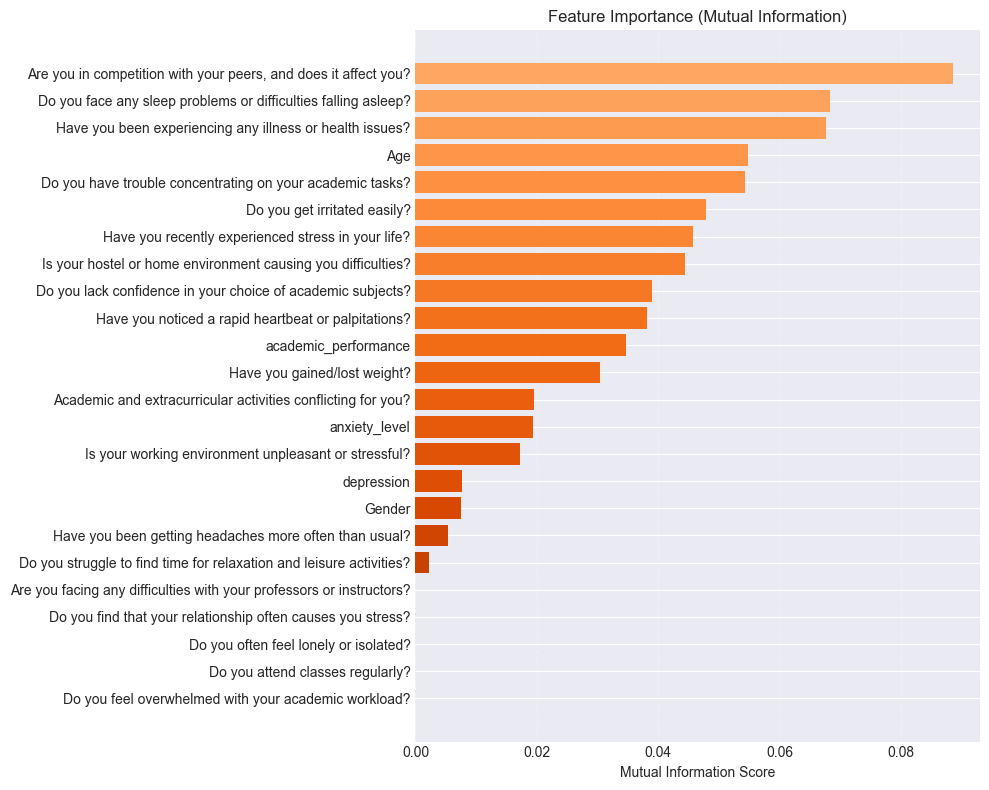

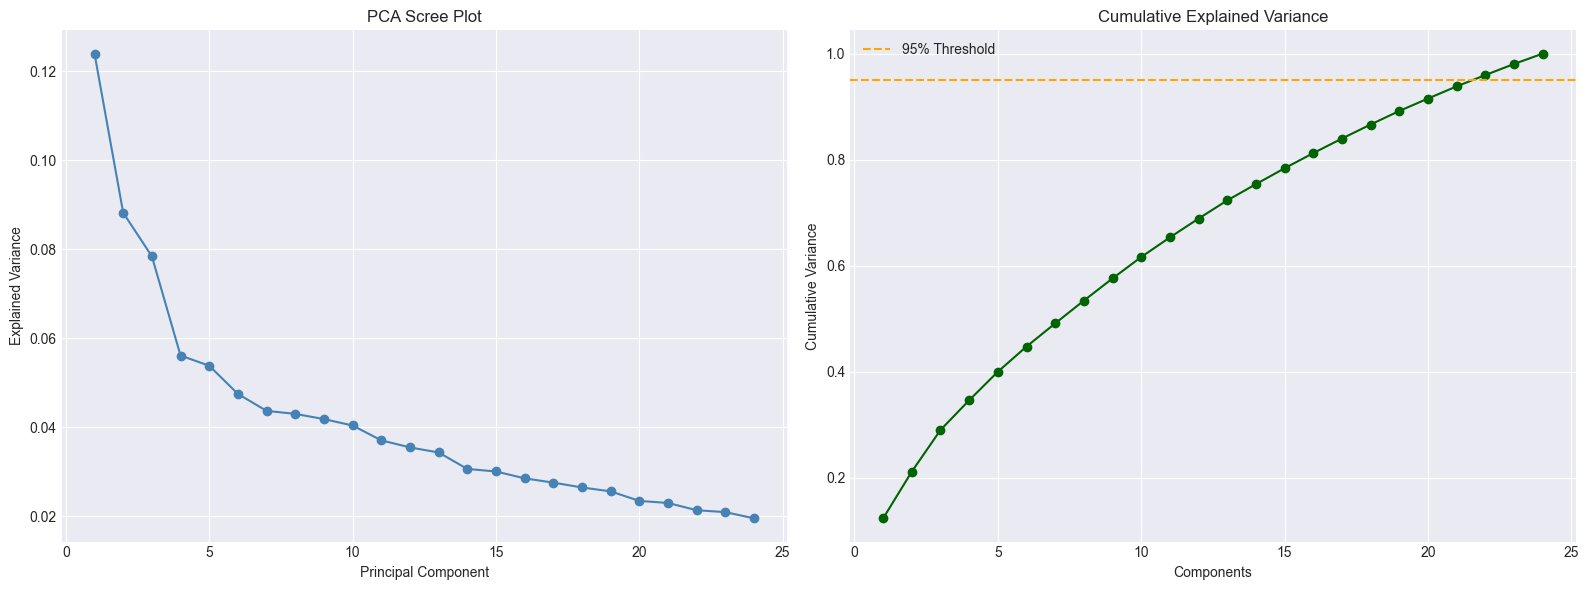


Number of components for 95% variance: 22

✅ Analysis complete. Files saved to ./output directory.


In [4]:

# ===============================
# 2. OUTPUT PATH CONFIGURATION
# ===============================
output_dir = "./Users/rudolphsurovcik/Library/CloudStorage/GoogleDrive-grs3@lehigh.edu/My Drive/Lehigh Fall 2025/BIS 411 - Fall 2025/Data Files/archive"
os.makedirs(output_dir, exist_ok=True)

# ===============================
# 3. INITIAL DATA EXPLORATION
# ===============================
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(df.head())

# ===============================
# 4. UNIVARIATE ANALYSIS
# ===============================
import math
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

num_features = len(df.columns)
n_cols = 3
n_rows = math.ceil(num_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    axes[idx].hist(df[col], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    if pd.api.types.is_numeric_dtype(df[col]):
        mean_val = df[col].mean()
        median_val = df[col].median()
        axes[idx].axvline(mean_val, color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='darkorange', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        axes[idx].legend()

for ax in axes[num_features:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_distributions.png'), dpi=300)
plt.show()

# ===============================
# 5. TARGET VARIABLE ANALYSIS
# ===============================
plt.figure(figsize=(10, 6))
stress_counts = df['stress_level'].value_counts().sort_index()
bars = plt.bar(stress_counts.index, stress_counts.values, edgecolor='black', color='teal', alpha=0.8)
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.title('Distribution of Stress Levels')
for i, v in enumerate(stress_counts.values):
    plt.text(stress_counts.index[i], v + 5, str(v), ha='center', fontweight='bold')
plt.savefig(os.path.join(output_dir, 'stress_level_distribution.png'), dpi=300)
plt.show()

# ===============================
# 6. CORRELATION MATRIX
# ===============================
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='YlGnBu', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'), dpi=300)
plt.show()

# Correlation with stress_level
stress_correlations = correlation_matrix['stress_level'].drop('stress_level').sort_values(ascending=False)

plt.figure(figsize=(10, 8))
colors = ['darkgreen' if x > 0 else 'darkorange' for x in stress_correlations]
stress_correlations.plot(kind='barh', color=colors)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Correlation with Stress Level')
plt.title('Feature Correlations with Stress Level')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'stress_correlations.png'), dpi=300)
plt.show()

# ===============================
# 7. MUTUAL INFORMATION
# ===============================
X = df.drop(columns=['stress_level', 'Which type of stress do you primarily experience?'])
y = df['stress_level']
for col in X.columns:
    if X[col].dtype == object:
        X[col] = X[col].astype('category').cat.codes

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores}).sort_values('MI Score', ascending=False)

plt.figure(figsize=(10, 8))
mi_colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(mi_scores_df)))
plt.barh(mi_scores_df['Feature'], mi_scores_df['MI Score'], color=mi_colors)
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'mutual_information_scores.png'), dpi=300)
plt.show()

# ===============================
# 8. PCA DIMENSIONALITY REDUCTION
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=np.number))
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'o-', color='steelblue')
ax1.set_title('PCA Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance')

ax2.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, 'o-', color='darkgreen')
ax2.axhline(y=0.95, color='orange', linestyle='--', label='95% Threshold')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xlabel('Components')
ax2.set_ylabel('Cumulative Variance')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=300)
plt.show()

n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNumber of components for 95% variance: {n_components_95}")

# ===============================
# 9. SAVE ANALYSIS SUMMARY
# ===============================
summary_report = f"""
STRESS LEVEL DATASET ANALYSIS SUMMARY
=====================================

Dataset Overview:
- Records: {df.shape[0]}
- Features: {df.shape[1]}
- Output files stored in: {output_dir}

Target Class Distribution:
{stress_counts.to_dict()}

Top Features by Correlation:
{stress_correlations.head(5).to_dict()}

Top Features by Mutual Information:
{mi_scores_df.head(5).set_index('Feature').to_dict()['MI Score']}

PCA: Components to reach 95% variance = {n_components_95}
"""

with open(os.path.join(output_dir, 'analysis_summary.txt'), 'w') as f:
    f.write(summary_report)

print("\n✅ Analysis complete. Files saved to ./output directory.")